# nb104: VFE neural layers

In nb102, we implemented the custom layers and models used in VoxelNet's convolutional middle layers and RPN layer.

In nb103, we implemented the first parts of the Voxel Feature Encoder: Partitioning, grouping, and sampling.

It uses a naive sparse representation (i.e. encoding as (D, H, W, T, 7) rather than (K, T, 7)), and it adds the offsets "live" (as a preprocessing step rather than in a layer. So, nb103 will need to be revisited.

But for now, let's finish connecting nb103 to nb102, by defining our custom layers composing the neural part of the VFE!


TODO: Define each layer, write up docstrings, fit together to VFE model.

In [1]:
import math
import os
import random
import sys
import struct
import warnings

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K


## 1. Fully connected component 

This network uses a fully-connected component which is a sequential stacking of a linear layer, batchnorm, and relu.

Weights should be 7x16: (7, 16)


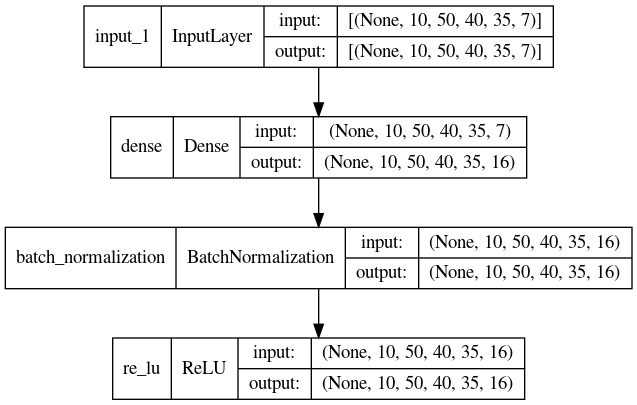

In [2]:
# Play example

# Pretend D, W, H = 10, 50, 40
fcn_input = keras.Input(
    shape = (10, 50, 40, 35, 7)
)
fcn_linear = keras.layers.Dense(16)
fcn_bn = keras.layers.BatchNormalization()
fcn_relu = keras.layers.ReLU()
fcn_out = fcn_relu(fcn_bn(fcn_linear(fcn_input)))

print(f"Weights should be 7x16: {fcn_linear.weights[0].shape}")

fcn = keras.Model(inputs = fcn_input, outputs = fcn_out)

keras.utils.plot_model(fcn, show_shapes=True)

In [3]:
class VFE_FCN:
    '''The fully-connected layer used for the VFE.
    
    :param CC: Dimension of input
    :type CC: int
    :param name: Suffix of names to be given to layers
    :type name: str
    '''
    def __init__(self, CC = 32, name = "VFE_FCN"):
        super(VFE_FCN, self).__init__(name=name)
        
        self.linear = keras.layers.Dense(CC, name = f"{name}_linear")
        self.bn = keras.layers.BatchNormalization(name = f"{name}_bn")
        self.relu = keras.layers.ReLU(name = f"{name}_fcn")
    
    def call(self, xx):
        '''
        :param xx: Input tensor
        :type xx: Tensor
        '''
        return self.relu(self.bn(self.linear(xx)))

## 2. Elementwise Maxpool

It is necessary to maxpool over the $T=35$ dimension, to convert the point-wise features to voxel-wise features.

This network should implement an optional 'keepdims' parameter to make it easy to use.

In retrospect, it was not even necessary to define a custom layer here. `tf.keras.layers.Maximum` might work? Or `tf.reduce_max(...)`.

In [4]:
class ElementwiseMaxpool:
    '''
    :param axis: Axis to maxpool over
    :type axis: int
    :param keepdims: If true, reduced axes are not deleted.
    E.g. (3, 3, 35) over axis 2 becomes (3, 3, 1).
    :type keepdims: bool
    :param name: Suffix of names to be given to layers
    :type name: str
    '''
    def __init__(self, axis = 3, keepdims = True, name = "VFE_ElementwiseMaxpool"):
        super(ElementwiseMaxpool, self).__init__(name=name)
        self.axis = axis
        self.keepdims = keepdims
        
    def call(self, xx):
        '''
        :param xx: Input tensor to be maxpooled
        :type xx: Tensor
        :return: Output tensor after maxpooling operation
        :rtype: Tensor
        '''
        return tf.reduce_max(xx, axis = self.axis, keepdims = self.keepdims)

# 3. Pointwise concat

After the FCN layers and the maxpool layer, the VFE ends up with a $(T, C)$ pointwise feature (e.g. $(35, 16)$) and an aggregate $(C,)$ feature (e.g. $(16,)$.

As the paper describes it, this is concatenated as $\left[f_i^T, \tilde{f}^T\right]^T \in \mathbb{R}^{2m} \forall i \in 1 ... t$.

Essentially, we broadcast the maxpooled aggregate feature and concatenate it over the pointwise features.

TODO: Needs simple testing.

In [29]:
class PointwiseConcat:
    '''Given two inputs, broadcast the second over a given axis to match 
    the first, and then concatenate them.
    
    :param axis: Axis to repeat over
    :type axis: int
    :param name: Suffix of names to be given to layers
    :type name: str
    '''
    def __init__(self, axis = 3, name = "VFE_FCN"):
        super(VFE_PointwiseConcat, self).__init__(name=name)
        self.axis = axis
        
    def call(self, xx):
        '''
        :param xx: Input tensor
        :type xx: Tensor
        '''
        # 1. make sure shape makes sense
        X1 = xx[0] # pointwise
        X2 = xx[1] # aggregate
        assert X1.shape == X2.shape + 1
        
        # 2. Get num to repeat
        num_to_repeat = X1.shape[self.axis]
        
        # 3. expand_dims, repeat,
        X2_wip = tf.expand_dims(X2, axis = self.axis)
        X2_wip = tf.repeat(X2, num_to_repeat, axis = self.axis)
        assert X2_wip.shape == X1.shape
        
        return tf.concat([X1, X2_wip], axis = self.axis)

In [13]:
# test
# (K, T = 3, 7 = 2) and (K, 7 = 2)
fiout  = np.array(
    [[1, 2],
     [4, 5],
     [7, 8]]
)

fiout = tf.convert_to_tensor(fiout)

ftot  = np.array(
    [10, 20]
)

ftot = tf.convert_to_tensor(ftot)

In [19]:
fiout

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[1, 2],
       [4, 5],
       [7, 8]])>

In [21]:
ftotp = tf.expand_dims(ftot, axis = 1)
ftotp

<tf.Tensor: shape=(2, 1), dtype=int64, numpy=
array([[10],
       [20]])>

In [25]:
ftotpr = tf.repeat(ftotp, repeats = 3, axis = 1)

In [27]:
ftotprt = tf.transpose(ftotpr)

In [28]:
tf.concat([fiout, ftotprt], axis=1)

<tf.Tensor: shape=(3, 4), dtype=int64, numpy=
array([[ 1,  2, 10, 20],
       [ 4,  5, 10, 20],
       [ 7,  8, 10, 20]])>

In [6]:
tf.__version__

'2.0.0'

## 4. VFE layer

The VFE layer chains the linear part, elementwise maxpool, and pointwise concatenation into a block. 

This requires all of those to work, so this is a TODO.

In [ ]:
class VFE(keras.layers.Layer):
    '''
    :param cin: Dimensionality of input points
    :type cin: int
    :param cout:  Dimension of output
    :type cout: int  
    :param cout: Max number of points in voxel, needed for repeat
    :type cout: int  
    :param name: Suffix of names to be given to layers
    :type name: str  
    '''
    def __init__(
        self,
        cin = 7,
        cout = 32,
        T = 35,
        name = "VFE"
    ):
        super(VFE, self).__init__(name=name)
        self.fcn = VFE_FCN(CC = cin, name = f"{name}_fcn")
        self.elementwise_maxpool = ElementwiseMaxpool(
            axis = 3,
            keepdims = True
            name = f"{name}_elementwise_maxpool"
        )
        self.pointwise_concat = PointwiseConcat(
            axis = 3,
            nn = T,
            name = f"{name}_pointwise_concat"
        )
        
    def call(
        self,
        xx
    ):
        '''
        :param xx: Input tensor
        :type xx: Tensor
        
        :return: Output of layer
        :rtype: Tensor
        '''
        pointwise_features = self.fcn(xx)
        aggregate_features = self.elementwise_maxpool(pointwise_features)
        
        return self.pointwise_concat([pointwise_features, aggregate_features])


# 5. VFE Out layer

The paper uses stacked layers, `VFE1(7, 32)` and `VFE2(32, 128)`. 

So, the network is roughly:

1. Input $(10, 400, 352, 35, 7)$
2. `VFE1` outputs $(10, 400, 352, 35, 32)$
3. `VFE2` outputs $(10, 400, 352, 35, 128)$

For the convolutional layers, we need to get rid of the $T=35$, to get input $(10, 400, 352, 128)$.

This layer uses ElementWise Maxpool, so it requires that for this to work!

In [ ]:
class VFE_out:
    '''Connects VFE-n layer to the convolutional middle layers.
    
    :param CC: Dimension of input
    :type CC: int
    :param axis: Axis to maxpool over
    :type axis: int
    :param name: Suffix of names to be given to layers
    :type name: str
    '''
    def __init__(self, CC = 128, axis = 3, name = "VFE_out"):
        super(VFE_out, self).__init__(name=name)
        
        self.fcn = VFE_FCN(CC=CC, name = f"{name}_fcn")
        self.elementwise_maxpool = ElementwiseMaxpool(
            axis = 3,
            keepdims = False
            name = f"{name}_elementwise_maxpool"
        )
    
    def call(self, xx):
        '''
        :param xx: Input tensor
        :type xx: Tensor
        
        
        :return: Output of layer
        :rtype: Tensor
        '''
        return self.elementwise_maxpool(self.fcn(xx))